In [62]:
import sys
import os
import json
from tqdm import tqdm
from utils.osutils import isfile

sys.path.insert(0, 'cocoapi/PythonAPI')
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

In [3]:
 import os
import numpy as np
import json
import random
import math
import cv2
import skimage
import skimage.transform

import torch
import torch.utils.data as data

from utils.osutils import *
from utils.imutils import *
from utils.transforms import *

In [1]:
det = 'data/COCO2017/annotations/person_detection_minival411_human553.json'
gt = 'data/COCO2017/annotations/person_keypoints_val2017.json'
target = 'data/COCO2017/annotations/COCO_2017_val.json'
mini = 'data/COCO2017/annotations/person_keypoints_minival2014.json'
img_folder = 'data/COCO2017/train2017'

In [4]:
with open(det) as f:
    det_anno = json.load(f)

with open(gt) as f:
    gt_anno = json.load(f)
    
with open(target) as f:
    tar_anno = json.load(f)
    
with open(mini) as f:
    min_anno = json.load(f)

In [5]:
def image_cropping(img, bbox, joints=None):
        height, width = 256, 192
        pixel_means = np.array([122.7717, 115.9465, 102.9801])
        bbox_extend_factor = (0.1, 0.15)
        is_train = True
        
        add = max(img.shape[0], img.shape[1])
        bimg = cv2.copyMakeBorder(img, add, add, add, add, borderType=cv2.BORDER_CONSTANT,
                            value=pixel_means.tolist())
        bbox = np.array(bbox).reshape(4, ).astype(np.float32)
        objcenter = np.array([bbox[0] + bbox[2] / 2., bbox[1] + bbox[3] / 2.])
        bbox += add         # bbox[:2] += add
        objcenter += add
        crop_width = (bbox[2] - bbox[0]) * (1 + bbox_extend_factor[0] * 2)
        crop_height = (bbox[3] - bbox[1]) * (1 + bbox_extend_factor[1] * 2)

        if is_train:
            joints[:, :2] += add
            inds = np.where(joints[:, -1] == 0)
            joints[inds, :2] = - 1000000

        if is_train:
            crop_width = crop_width * (1 + 0.25)
            crop_height = crop_height * (1 + 0.25)  

        if crop_height / height > crop_width / width:
            crop_size = crop_height
            min_shape = height
        else:
            crop_size = crop_width
            min_shape = width

        crop_size = min(crop_size, objcenter[0] / width * min_shape * 2. - 1.)
        crop_size = min(crop_size, (bimg.shape[1] - objcenter[0]) / width * min_shape * 2. - 1)
        crop_size = min(crop_size, objcenter[1] / height * min_shape * 2. - 1.)
        crop_size = min(crop_size, (bimg.shape[0] - objcenter[1]) / height * min_shape * 2. - 1)

        min_x = int(objcenter[0] - crop_size / 2. / min_shape * width)
        max_x = int(objcenter[0] + crop_size / 2. / min_shape * width)
        min_y = int(objcenter[1] - crop_size / 2. / min_shape * height)
        max_y = int(objcenter[1] + crop_size / 2. / min_shape * height)                               

        x_ratio = float(width) / (max_x - min_x)
        y_ratio = float(height) / (max_y - min_y)

        if is_train:
            joints[:, 0] = joints[:, 0] - min_x
            joints[:, 1] = joints[:, 1] - min_y

            joints[:, 0] *= x_ratio
            joints[:, 1] *= y_ratio
            # label = joints[:, :2].copy()
            # valid = joints[:, 2].copy()

        img = cv2.resize(bimg[min_y:max_y, min_x:max_x, :], (width, height))
        details = np.asarray([min_x - add, min_y - add, max_x - add, max_y - add]).astype(np.float)

        if is_train:
            return img, joints, details
        else:
            return img, details

In [6]:
def data_augmentation(img, label, operation):
        scale_factor = (0.7, 1.35)
        rot_factor=45
        symmetry = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]
    
        height, width = img.shape[0], img.shape[1]
        center = (width / 2., height / 2.)
        num = label.shape[0]

        # affine augmentation
        affrat = random.uniform(scale_factor[0], scale_factor[1])
        halfl_w = min(width - center[0], (width - center[0]) / 1.25 * affrat)
        halfl_h = min(height - center[1], (height - center[1]) / 1.25 * affrat)
        img = skimage.transform.resize(img[int(center[1] - halfl_h): int(center[1] + halfl_h + 1),
                int(center[0] - halfl_w): int(center[0] + halfl_w + 1)], (height, width))

        for i in range(num):
            label[i][0] = (label[i][0] - center[0]) / halfl_w * (width - center[0])+ center[0]
            label[i][1] = (label[i][1] - center[1]) / halfl_h * (height - center[1]) + center[1]
            label[i][2] *= (
                (label[i][0] >= 0) & (label[i][0] < width) & (label[i][1] >= 0) & (label[i][1] < height))
        
        # flip augmentation
        if operation == 1:
            img = cv2.flip(img, 1)
            cod = []
            allc = []
            for i in range(num):
                x, y = label[i][0], label[i][1]
                if x >= 0:
                    x = width - 1 - x
                cod.append((x, y, label[i][2]))

            # **** the joint index depends on the dataset ****
            for (q, w) in symmetry:
                cod[q], cod[w] = cod[w], cod[q]
            for i in range(num):
                allc.append(cod[i][0])
                allc.append(cod[i][1])
                allc.append(cod[i][2])
            label = np.array(allc).reshape(num, 3)
        
        # rorated augmentation
        if operation > 1:      
            angle = random.uniform(0, rot_factor)
            if random.randint(0, 1):
                angle *= -1
            rotMat = cv2.getRotationMatrix2D(center, angle, 1.0)
            img = cv2.warpAffine(img, rotMat, (width, height))
            
            allc = []
            for i in range(num):
                x, y = label[i][0], label[i][1]
                state = label[i][2]
                coor = np.array([x, y])
                if x >= 0 and y >= 0:
                    R = rotMat[:, : 2]
                    W = np.array([rotMat[0][2], rotMat[1][2]])
                    coor = np.dot(R, coor) + W
                allc.append(int(coor[0]))
                allc.append(int(coor[1]))
                state *= ((coor[0] >= 0) & (coor[0] < width) & (coor[1] >= 0) & (coor[1] < height))
                allc.append(int(state))
            label = np.array(allc).reshape(num, 3).astype(np.int)
        return img, label

In [198]:
def data_augmentation1(img, label, operation):
        scale_factor = (0.7, 1.35)
        rot_factor=45
        symmetry = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]
    
        height, width = img.shape[0], img.shape[1]
        center = (width / 2., height / 2.)
        n = label.shape[0]
        affrat = random.uniform(scale_factor[0], scale_factor[1])
        
        halfl_w = min(width - center[0], (width - center[0]) / 1.25 * affrat)
        halfl_h = min(height - center[1], (height - center[1]) / 1.25 * affrat)
        img = skimage.transform.resize(img[int(center[1] - halfl_h): int(center[1] + halfl_h + 1),
                             int(center[0] - halfl_w): int(center[0] + halfl_w + 1)], (height, width))
        for i in range(n):
            label[i][0] = (label[i][0] - center[0]) / halfl_w * (width - center[0]) + center[0]
            label[i][1] = (label[i][1] - center[1]) / halfl_h * (height - center[1]) + center[1]
            label[i][2] *= (
            (label[i][0] >= 0) & (label[i][0] < width) & (label[i][1] >= 0) & (label[i][1] < height))

        # flip augmentation
        if operation == 1:
            img = cv2.flip(img, 1)
            cod = []
            allc = []
            for i in range(n):
                x, y = label[i][0], label[i][1]
                if x >= 0:
                    x = width - 1 - x
                cod.append((x, y, label[i][2]))
            # **** the joint index depends on the dataset ****    
            for (q, w) in symmetry:
                cod[q], cod[w] = cod[w], cod[q]
            for i in range(n):
                allc.append(cod[i][0])
                allc.append(cod[i][1])
                allc.append(cod[i][2])
            label = np.array(allc).reshape(n, 3)

        # rotated augmentation
        if operation > 1:      
            angle = random.uniform(0, rot_factor)
            if random.randint(0, 1):
                angle *= -1
            rotMat = cv2.getRotationMatrix2D(center, angle, 1.0)
            img = cv2.warpAffine(img, rotMat, (width, height))
            
            allc = []
            for i in range(n):
                x, y = label[i][0], label[i][1]
                v = label[i][2]
                coor = np.array([x, y])
                if x >= 0 and y >= 0:
                    R = rotMat[:, : 2]
                    W = np.array([rotMat[0][2], rotMat[1][2]])
                    coor = np.dot(R, coor) + W
                allc.append(int(coor[0]))
                allc.append(int(coor[1]))
                v *= ((coor[0] >= 0) & (coor[0] < width) & (coor[1] >= 0) & (coor[1] < height))
                allc.append(int(v))
            label = np.array(allc).reshape(n, 3).astype(np.int)
        return img, label

In [7]:
val_path = 'data/COCO2017/annotations/COCO_2017_train1.json'

with open(val_path) as f:
    val_anno = json.load(f)

In [253]:
item = val_anno[10]
img_name = item['img_info']['img_path']
img_path = os.path.join(img_folder, img_name)
num_skeleton = 17

points = np.array(item['input']['keypoints']).reshape(num_skeleton, 3).astype(np.float32)
gt_bbox = item['input']['bbox']

image = scipy.misc.imread(img_path, mode='RGB')

/home/shuhao/anaconda3/envs/pt/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


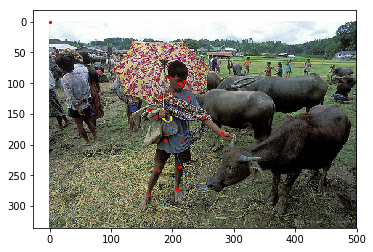

In [254]:
plt.imshow(image)

plt.scatter(x=points[:,0], y=points[:,1], c='r', s=5)
plt.show()

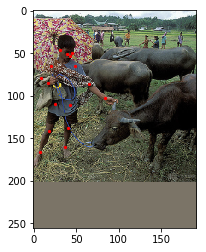

In [255]:
image1, points1, details = image_cropping(image, gt_bbox, points)

X = []
Y = []
for p in points1:
    if p[2] != 0:
        X.append(p[0])
        Y.append(p[1])


plt.imshow(image1)

plt.scatter(x=X, y=Y, c='r', s=5)
plt.show()

In [256]:
image2, points2 = data_augmentation1(image, points, 1)

X = []
Y = []

print(points2)


[[-4.50254517e+01  4.39848185e+00  0.00000000e+00]
 [-5.04515495e+01  7.66046405e-01  0.00000000e+00]
 [-4.14080467e+01 -1.05017412e+00  0.00000000e+00]
 [-6.22081070e+01 -5.59072018e+00  0.00000000e+00]
 [-9.05041938e+05 -9.08652312e+05  0.00000000e+00]
 [-7.66777115e+01  2.16525555e+01  0.00000000e+00]
 [-3.59819450e+01  2.16525555e+01  0.00000000e+00]
 [-9.29560165e+01  4.16309471e+01  0.00000000e+00]
 [-1.24688396e+01  5.16201515e+01  0.00000000e+00]
 [-8.21038132e+01  4.98039322e+01  0.00000000e+00]
 [ 4.85242678e+02  7.52309875e+01  2.00000000e+00]
 [-6.94429092e+01  8.52201843e+01  0.00000000e+00]
 [-4.50254517e+01  8.61282959e+01  0.00000000e+00]
 [-8.02951126e+01  1.30625641e+02  0.00000000e+00]
 [-4.86428490e+01  1.25176987e+02  0.00000000e+00]
 [-9.47647171e+01  1.66041885e+02  0.00000000e+00]
 [-5.22602501e+01  1.57868912e+02  0.00000000e+00]]


/home/shuhao/anaconda3/envs/pt/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/shuhao/anaconda3/envs/pt/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


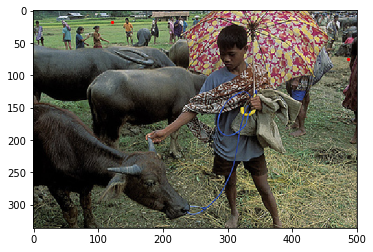

In [258]:
for p in points2:
    if p[2] != 0:
        X.append(p[0])
        Y.append(p[1])


plt.imshow(image2)


plt.scatter(x=X, y=Y, c='r', s=5)
plt.show()